<a href="https://colab.research.google.com/github/JayNguyen-123/Toxic_Comments_Classification/blob/main/Toxic_Comments_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Toxic Comments Classification with LSTM-based Model
- Long Short-Term Memory (LSTM) is an enhanced version of the Recurrent Neural Network (RNN) designed by Hochreiter and Schmidhuber. LSTMs can capture long-term dependencies in sequential data making them ideal for tasks like language translation, speech recognition and time series forecasting.

- Unlike traditional RNNs which use a single hidden state passed through time LSTMs introduce a memory cell that holds information over extended periods addressing the challenge of learning long-term dependencies.

In [1]:
# Load dependencies
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.metrics import Precision, Recall


In [2]:
# Load and explore data
train_df = pd.read_csv("/content/train.csv")
train_df.head()



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train_df.shape


(159571, 8)

In [4]:
train_df.iloc[0]['comment_text']


"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [5]:
# Preprocess the data
X = train_df['comment_text']
y = train_df[train_df.columns[2:]].values    #selecting all columns from the third column onwards.

X

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."
...,...
159566,""":::::And for the second time of asking, when ..."
159567,You should be ashamed of yourself \n\nThat is ...
159568,"Spitzer \n\nUmm, theres no actual article for ..."
159569,And it looks like it was actually you who put ...


In [6]:
y


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [7]:
max_features = 200000    # number of words in vocab
max_len = 1800   # sequence length to pad the outputs

vectorizer = TextVectorization(max_tokens=max_features,
                               output_sequence_length=max_len,
                               output_mode='int')     # this will map every single word to an integer value

vectorizer.adapt(X.values)


In [8]:
vectorized_text = vectorizer(X.values)
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [9]:
# Build data pipeline
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)      # how large our buffer size needs to be
dataset = dataset.batch(16)       # each batch represented as a series of 16 samples
dataset = dataset.prefetch(8)        # helps prevent bottle necks


In [10]:
one_batch = dataset.as_numpy_iterator().next()         # batch of 16 training example
one_batch

(array([[  277, 37769,  7594, ...,     0,     0,     0],
        [  729,   898,  3101, ...,     0,     0,     0],
        [   10,   161,     8, ...,     0,     0,     0],
        ...,
        [  490,  7472,    38, ...,     0,     0,     0],
        [ 1589,    20,   861, ...,     0,     0,     0],
        [  490, 50164,    12, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0]]))

In [11]:
len(one_batch[0])


16

In [12]:
# Data Splitting
print(f"The dataset contains {len(dataset)} batch")


The dataset contains 9974 batch


In [13]:
train = dataset.take(int(len(dataset) * .9))     # 90%
val = dataset.skip(int(len(dataset) * .7)).take(int(len(dataset) * .05))     # 5%
test = dataset.skip(int(len(dataset) * .9)).take(int(len(dataset) * .05))    # 5%

In [14]:
len(train), len(val), len(test)


(8976, 498, 498)

In [15]:
# Build the model
model = Sequential()

# Create the embedding layer
model.add(Embedding(max_features+1, 32))

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Final layer
model.add(Dense(6, activation='sigmoid'))


In [16]:
model.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Training
hist = model.fit(train, epochs=3, validation_data=val, verbose=1)


Epoch 1/3
8976/8976 ━━━━━━━━━━━━━━━━━━━━ 766s 85ms/step - accuracy: 0.9323 - loss: 0.0779 - val_accuracy: 0.9933 - val_loss: 0.0444
Epoch 2/3
8976/8976 ━━━━━━━━━━━━━━━━━━━━ 766s 85ms/step - accuracy: 0.9891 - loss: 0.0436 - val_accuracy: 0.9952 - val_loss: 0.0366
Epoch 3/3
8976/8976 ━━━━━━━━━━━━━━━━━━━━ 812s 86ms/step - accuracy: 0.9878 - loss: 0.0385 - val_accuracy: 0.9941 - val_loss: 0.0315


In [19]:
# Model evaluation
loss, Acc = model.evaluate(test)
print("Test Loss: ", loss)
print("Test Accuracy: ", Acc)


498/498 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.9944 - loss: 0.0312
Test Loss:  0.03252479061484337
Test Accuracy:  0.9954819083213806


<Figure size 800x500 with 0 Axes>

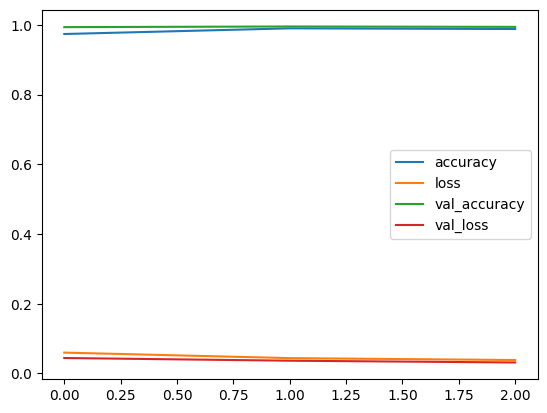

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(hist.history).plot()
plt.show()


In [22]:
# Make predictions
input_text = vectorizer("You feaking suck! I am going to beat you.")
res = model.predict(np.expand_dims(input_text, axis=0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


In [23]:
(res > 0.5).astype(int)


array([[1, 0, 1, 0, 1, 0]])

In [24]:
train_df.columns[2:]


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [25]:
# Calculating Precision and Recall
pre = Precision()
re = Recall()

for batch in test.as_numpy_iterator():
  # unpack the batch
  X_test, y_test = batch
  # make a prediction
  y_pred = model.predict(X_test)

  y_test = y_test.flatten()
  y_pred = y_pred.flatten()

  pre.update_state(y_test, y_pred)
  re.update_state(y_test, y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━

In [26]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}")


Precision: 0.8777022957801819, Recall: 0.8001126050949097


### Toxic Comments Classification with TF-IDF.
- TF-IDF, which stands for Term Frequency-Inverse Document Frequency, is a numerical statistic that reflects how important a word is to a document in a collection or corpus. It's a widely used technique in information retrieval and text mining, particularly for search optimization and text analysis. The TF-IDF score is calculated by multiplying two metrics: Term Frequency (TF) and Inverse Document Frequency (IDF).

- Term Frequency (TF):
TF measures how frequently a term (word) appears in a document.
A higher term frequency means the word is more prominent within that specific document.
Common formulas for calculating TF include raw count (number of times the term appears) or normalized frequency (adjusted for document length).

- Inverse Document Frequency (IDF):
IDF measures how important a term is across the entire document collection (corpus).
It quantifies how common or rare a term is across all documents.
A higher IDF suggests the term is rare and potentially more informative.
The formula for IDF often includes a logarithm to dampen the effect of very frequent terms, and it may add 1 to the denominator to avoid division by zero when a term doesn't appear in some documents.

In [28]:
import pandas as pd
import numpy as np


In [29]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

pd.set_option('display.max_rows', None)

df = pd.concat([df_train, df_test])


In [31]:
df_train['comment_text'] = df_train['comment_text'].str.lower()
df_test['comment_text'] = df_test['comment_text'].str.lower()

df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [33]:
import re

def remove_special_characters(text):
    text = re.sub(r'http\S+', ' ', text )
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\bhttps?://[a-zA-Z0-9-]+(?:\.[a-zA-Z0-9-]+)+\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d', ' ', text)  # Corrected line
    text= re.sub(r'[\u4e00-\u9fff]+', ' ', text)
    return text

df_train['comment_text'] = df_train['comment_text'].apply(remove_special_characters)
df_test['comment_text'] = df_test['comment_text'].apply(remove_special_characters)

print(df_train['comment_text'].head(15))



0     explanation why the edits made under my userna...
1     d aww he matches this background colour i m se...
2     hey man i m really not trying to edit war it s...
3     more i can t make any real suggestions on impr...
4     you sir are my hero any chance you remember wh...
5     congratulations from me as well use the tools ...
6          cocksucker before you piss around on my work
7     your vandalism to the matt shirvington article...
8     sorry if the word nonsense was offensive to yo...
9     alignment on this subject and which are contra...
10    fair use rationale for image wonju jpg thanks ...
11    bbq be a man and lets discuss it maybe over th...
12    hey what is it talk what is it an exclusive gr...
13    before you start throwing accusations and warn...
14    oh and the girl above started her arguments wi...
Name: comment_text, dtype: object


In [36]:
import nltk
from nltk import word_tokenize
nltk.download('punkt_tab')


df_train['word_tokens'] = df_train['comment_text'].apply(word_tokenize)
df_test['word_tokens'] = df_test['comment_text'].apply(word_tokenize)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


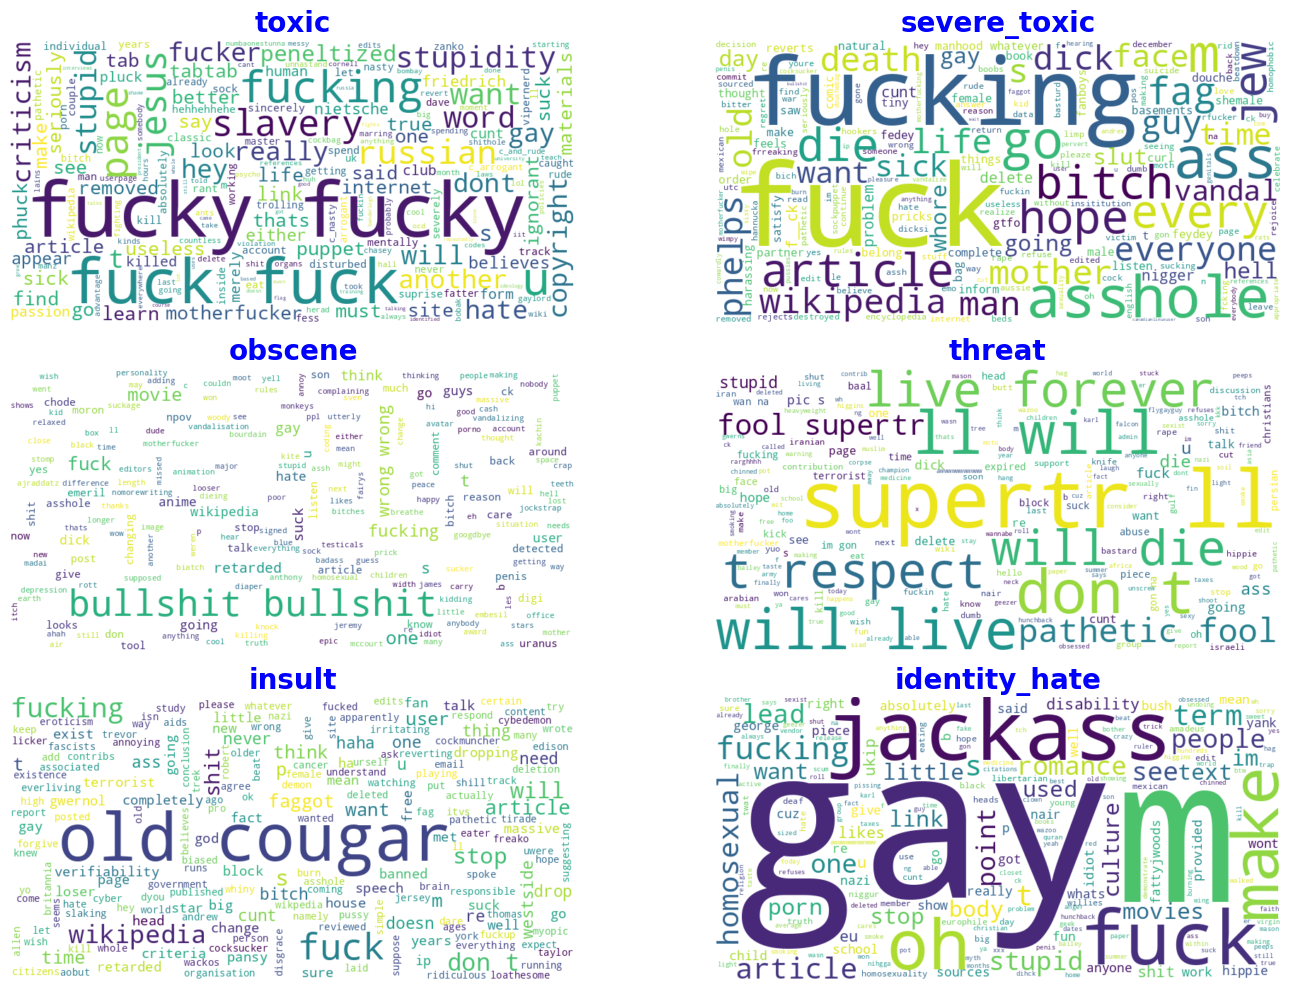

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Classes
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

def generate_wordcloud(tokens):
    flat_tokens = []
    for sublist in tokens:
        for token in sublist:
            flat_tokens.append(token)
    text = ' '.join(flat_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    return wordcloud

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

for i, class_name in enumerate(classes):
    row, col = np.unravel_index(i,(3, 2))

    class_tokens = df_train[df_train[class_name] == 1]['word_tokens']
    selected_tokens = class_tokens.sample(n=25)

    wordcloud = generate_wordcloud(selected_tokens)

    axs[row, col].imshow(wordcloud, interpolation='bilinear')
    axs[row, col].set_title(class_name, fontsize=20, fontweight='bold', color='blue')  # Highlight and bold title
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()



In [39]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_train, train_size=0.8, random_state=42)



In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

# Define the TfidfVectorizer with specified parameters
vec = TfidfVectorizer(ngram_range=(1, 2),
                      min_df=3,
                      max_df=0.9,
                      strip_accents='unicode',
                      use_idf=True,
                      smooth_idf=True,
                      sublinear_tf=False,
                      binary=True,
                      stop_words='english')


# Transform the training, validation, and test data
trn_term_doc = vec.fit_transform(df_train['comment_text'])
val_term_doc = vec.transform(valid['comment_text'])
test_term_doc = vec.transform(df_test['comment_text'])



In [46]:
x = trn_term_doc
val_x = val_term_doc


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

epsilon = 1e-9



In [53]:
# Define a function to calculate the probability of each word given a specific class (toxic or non-toxic)
def probability(y_i, y):
    # Sum the occurrences of each word in comments labeled with y_i (1 for toxic, 0 for non-toxic)
    occurences = x[y == y_i].sum(0)
    # Add a smoothing factor of 1 to avoid division by zero and handle words not present in some classes
    return (occurences + 1) / ((y == y_i).sum() + 1)

def get_model(y):
    # Convert the target labels to a numpy array
    y = y.values
    # Calculate the log-ratio of probabilities of each word being toxic vs. non-toxic
    loga = np.log((probability(1, y) + epsilon) / (probability(0, y) + epsilon) )
    # Multiply the input features by the log-ratio to incorporate the information about word toxicity
    x_loga = x.multiply(loga)
    # Initialize a logistic regression model with specified hyperparameters
    model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100, random_state=42)
    # Fit the model to the modified input features and target labels
    return model.fit(x_loga, y), loga


In [54]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_labels = df_train.drop(['comment_text'], axis=1)
valid_labels = valid.drop(['comment_text'], axis=1)


In [55]:
  # Dictionary to store ROC AUC scores for each class
model = {}
ROC_AUC_Scores = {}
for i, col in enumerate(classes):
    print(col)

    # Train model for current class
    model_trained, loga = get_model(train_labels[col])
    model[col] = (model_trained, loga)
    # Make predictions on validation set
    preds = model_trained.predict(val_x.multiply(loga)).reshape(-1, 1)

    # Calculate ROC AUC score for current class and store it
    roc_auc = roc_auc_score(valid_labels[col], preds)
    ROC_AUC_Scores[col] = roc_auc
    # Print ROC AUC scores for each class
for col, roc_auc in ROC_AUC_Scores.items():
    print(f"ROC AUC for class: '{col}': {roc_auc}")


toxic
severe_toxic
obscene
threat
insult
identity_hate
ROC AUC for class: 'toxic': 0.882298818964349
ROC AUC for class: 'severe_toxic': 0.8593699620003561
ROC AUC for class: 'obscene': 0.9121859131542873
ROC AUC for class: 'threat': 0.9661534041186063
ROC AUC for class: 'insult': 0.8711052432334527
ROC AUC for class: 'identity_hate': 0.8808416950158198


In [56]:
preds = np.zeros((len(df_test), len(classes)))

for i, col in enumerate(classes):
  print(col)
  preds[:, i] = model[col][0].predict_proba(test_term_doc.multiply(model[col][1]))[:, 1]


toxic
severe_toxic
obscene
threat
insult
identity_hate


In [57]:
submit = pd.DataFrame({'id': df_test.index})    # use index as 'id' column
submission = pd.concat([submit, pd.DataFrame(preds, columns=classes)], axis=1)
submission.to_csv('submission.csv', index=False)


In [58]:
submission.head()


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0.999950,0.077125,0.999502,0.005494,0.965543,0.186204
1,1,0.005033,0.001199,0.003409,0.000412,0.005956,0.001228
2,2,0.012523,0.000839,0.004402,0.000413,0.006708,0.001066
3,3,0.004258,0.000925,0.003341,0.000551,0.003943,0.000840
4,4,0.026765,0.001160,0.005383,0.000411,0.008904,0.001018
